In [39]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy

from sklearn.model_selection import train_test_split

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.14.0'

In [3]:
# importing files
import zipfile
with zipfile.ZipFile('./Trafficdataset_Signtypes.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [40]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('./Trafficdataset_Signtypes/*/*.png', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

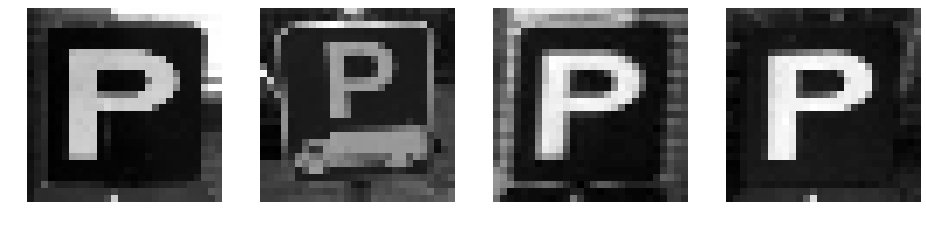

In [41]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [6]:
data.label.unique()

array(['parking', 'stop', 'rightofway', 'warning', 'limitedtraffic',
       'noparking', 'speed', 'bicycle', 'giveway', 'traveldirection',
       'continue', 'crossing', 'trafficdirective', 'noentry', 'laneend',
       'roundabout'], dtype=object)

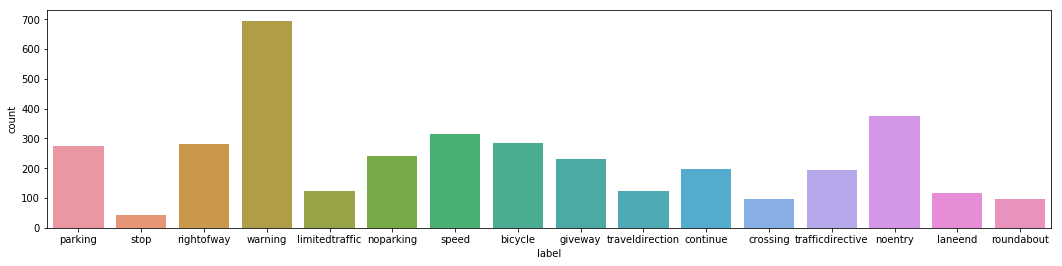

In [9]:
import seaborn as sns
plt.figure(figsize=(18,4))
sns.countplot(x='label', data=data)

In [10]:
d = {'parking':0, 'stop':1, 'rightofway':2, 'warning':3, 'limitedtraffic':4, 'noparking':5,
     'speed':6, 'bicycle':7, 'giveway':8, 'traveldirection':9, 'continue':10, 'crossing':11, 'trafficdirective':12,
     'noentry':13, 'laneend':14, 'roundabout':15}
data['labels_num'] = data['label'].map(d, na_action='ignore')

In [12]:
temptrainData, testData = train_test_split(data ,test_size=0.20, random_state=42)
trainData, validateData = train_test_split(temptrainData ,test_size=0.25, random_state=42)

In [13]:
print(trainData.shape)
print(testData.shape)
print(validateData.shape)

(2219, 3)
(740, 3)
(740, 3)


In [17]:
N_train_images = trainData.shape[0]
N_val_images = validateData.shape[0]
N_test_images = testData.shape[0]

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validateData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(16))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
activation_20 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_21 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_22 (Activation)   (None, 9, 9, 64)         

In [33]:
model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=50)

Epoch 1/50
139/139 [==============================] - 3s 25ms/step - loss: 2.7221 - categorical_accuracy: 0.1559 - val_loss: 2.6115 - val_categorical_accuracy: 0.1986
Epoch 2/50
139/139 [==============================] - 3s 22ms/step - loss: 2.6586 - categorical_accuracy: 0.1794 - val_loss: 2.5642 - val_categorical_accuracy: 0.1986
Epoch 3/50
139/139 [==============================] - 3s 21ms/step - loss: 2.6321 - categorical_accuracy: 0.1834 - val_loss: 2.5167 - val_categorical_accuracy: 0.1986
Epoch 4/50
139/139 [==============================] - 3s 21ms/step - loss: 2.5992 - categorical_accuracy: 0.1888 - val_loss: 2.4643 - val_categorical_accuracy: 0.2054
Epoch 5/50
139/139 [==============================] - 3s 21ms/step - loss: 2.5617 - categorical_accuracy: 0.2014 - val_loss: 2.3929 - val_categorical_accuracy: 0.2878
Epoch 6/50
139/139 [==============================] - 3s 22ms/step - loss: 2.5269 - categorical_accuracy: 0.2204 - val_loss: 2.3132 - val_categorical_accuracy: 0.329

In [25]:
#Predicting

In [35]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = test_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
shuffle = False)

Found 740 validated image filenames belonging to 16 classes.


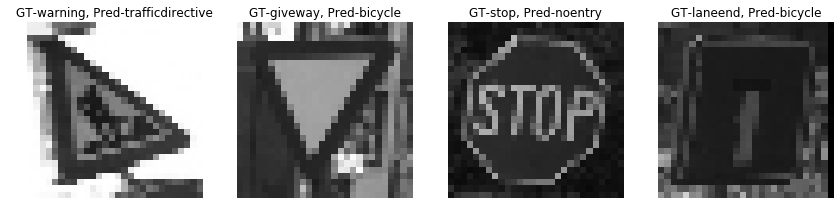

In [36]:
labels = (test_generator.class_indices)

d_inv = {v: k for k, v in labels.items()}
plt.figure(figsize=(22,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,6,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [37]:
# Random forest

In [38]:
data

,image_path,label,labels_num
0,./Trafficdataset_Signtypes/parking/00290_00001...,parking,0
1,./Trafficdataset_Signtypes/parking/01366_00000...,parking,0
2,./Trafficdataset_Signtypes/parking/00482_00000...,parking,0
3,./Trafficdataset_Signtypes/parking/01731_00000...,parking,0
4,./Trafficdataset_Signtypes/parking/00129_00001...,parking,0
5,./Trafficdataset_Signtypes/parking/00498_00000...,parking,0
6,./Trafficdataset_Signtypes/parking/01307_00000...,parking,0
7,./Trafficdataset_Signtypes/parking/01307_00001...,parking,0
8,./Trafficdataset_Signtypes/parking/00043_00002...,parking,0
9,./Trafficdataset_Signtypes/parking/01391_00000...,parking,0
